<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/hypotension_mbp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypotension prediction using mean blood pressure values

In this example, we will learn how to build a machine learning based model for predicting hypotension (MBP < 65mmHg for more than 1 minute) from the mean blood pressure (MBP) value read from the patient monitor (GE Solar 8000M) on VitalDB dataset.

> Note that <b>all users who use Vital DB, an open biosignal dataset, must agree to the Data Use Agreement below. 
</b> If you do not agree, please close this window. 
Click here: [Data Use Agreement](https://vitaldb.net/dataset/?query=overview&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.vcpgs1yemdb5)

## Required libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
#!pip install vitaldb
import vitaldb
import warnings
warnings.filterwarnings('ignore')

## Case Selection

In [2]:
df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # read track list
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # read case information

# inclusion & exclusion criteria
caseids = list(
    set(df_trks[df_trks['tname'] == 'Solar8000/ART_MBP']['caseid']) & \
    set(df_cases[df_cases['age'] > 18]['caseid']) & \
    set(df_cases[df_cases['caseend'] > 3600]['caseid']) & \
    set(df_cases[~df_cases['opname'].str.contains("transplant", case=False)]['caseid'])
)
print('Total {} cases found'.format(len(caseids)))
np.random.shuffle(caseids)  # shuffle caseids

Total 3420 cases found


## Preprocessing

In this section, we will read the MBP data while iterating caseids. Only MAX_CASES (=100) cases will be used for to save time.

The MBP data of each case will be read by passing the caseid into the vitaldb python library. Then, the pairs of x (input) and y (label) for training and validation of the model will be extracted.

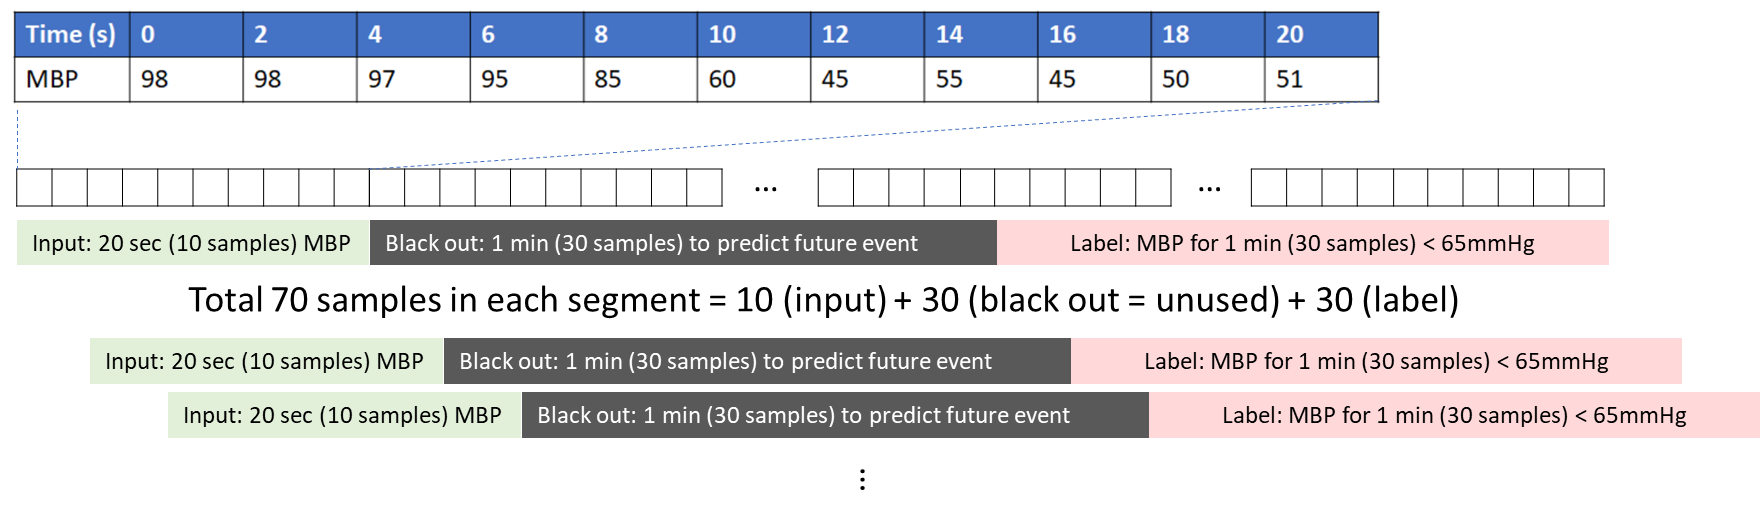

In [3]:
MINUTES_AHEAD = 1  # Predict hypotension 1 minutes ahead
LSTM_NODES = 16  # Number of cells in LSTM
BATCH_SIZE = 256  # Batch size for learning
MAX_CASES = 100  # Maximum number of cases for this example

# Final dataset for training and testing the model
x = []  # input with shape of (segements, timepoints)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segement
c = []  # caseid of each segment

# maximum number of cases
for caseid in caseids:
    print(f'loading {caseid}', end='...', flush=True)

    # read the mean blood pressure with 2 min interval
    mbps = vitaldb.load_case(caseid, ['Solar8000/ART_MBP'], 2).flatten()

    # samples before arterial catheter inserted
    mbps[mbps < 40] = np.nan

    # removing the nan values at the beginning and the ending
    case_valid_mask = ~np.isnan(mbps)
    mbps = mbps[(np.cumsum(case_valid_mask) > 0) & (np.cumsum(case_valid_mask[::-1])[::-1] > 0)]

    case_sample = 0
    case_event = 0
    for i in range(0, len(mbps) - (10 + MINUTES_AHEAD * 30 + 30)):
        segx = mbps[i:i + 10]
        segy = mbps[i + 10 + MINUTES_AHEAD * 30:i + 10 + MINUTES_AHEAD * 30 + 30]

        # check the validity of this segment
        valid = True
        if np.isnan(segx).mean() > 0.1:
            valid = False
        if np.isnan(segy).mean() > 0.1:
            valid = False
        elif (segx > 150).any():
            valid = False
        elif (segy > 150).any():
            valid = False
        elif (np.abs(np.diff(segx)) > 50).any():  # abrupt change -> noise
            valid = False
        elif (np.abs(np.diff(segy)) > 50).any():  # abrupt change -> noise
            valid = False

        evt = np.nanmax(segy) < 65
        x.append(segx)
        y.append(evt)
        valid_mask.append(valid)
        c.append(caseid)
        
        if valid:
            case_sample += 1
            if evt:
                case_event += 1

    if case_sample > 0:
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100*case_event/case_sample))
    else:
        print('no samples')

    if len(np.unique(c)) >= MAX_CASES:
        break

# final caseids
caseids = np.unique(c)

x = np.array(x)
y = np.array(y) 
valid_mask = np.array(valid_mask)
c = np.array(c)

# forward filling
x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

x = x[...,None]  # add 3rd axis for input of LSTM

print(x.shape)
print(y.shape)

loading 357...2335 samples 109 (4.7 %) events
loading 771...5902 samples 0 (0.0 %) events
loading 3596...1614 samples 51 (3.2 %) events
loading 4443...6105 samples 11 (0.2 %) events
loading 1144...4563 samples 165 (3.6 %) events
loading 5809...10921 samples 519 (4.8 %) events
loading 338...4645 samples 3 (0.1 %) events
loading 5404...5885 samples 353 (6.0 %) events
loading 2947...8010 samples 201 (2.5 %) events
loading 5184...3756 samples 176 (4.7 %) events
loading 1383...7309 samples 108 (1.5 %) events
loading 1708...12915 samples 584 (4.5 %) events
loading 6343...8561 samples 24 (0.3 %) events
loading 6180...2017 samples 42 (2.1 %) events
loading 655...6327 samples 0 (0.0 %) events
loading 3429...7062 samples 902 (12.8 %) events
loading 2240...3283 samples 200 (6.1 %) events
loading 5139...7531 samples 1222 (16.2 %) events
loading 1428...6355 samples 74 (1.2 %) events
loading 3628...2960 samples 0 (0.0 %) events
loading 755...3587 samples 56 (1.6 %) events
loading 1901...7545 samples

## Splitting samples into training and testing dataset


In [4]:
ncase = len(caseids)
ntest = int(ncase * 0.2)
ntrain = ncase - ntest
caseids_train = caseids[:ntrain]
caseids_test = caseids[ncase - ntest:ncase]

# train set과 test set 으로 나눔
train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)

# invalid samples in test dataset is also needed for plotting
test_x = x[test_mask]
test_y = y[test_mask]
test_c = c[test_mask]

# only valid samples are required for the training dataset
train_x_valid = x[train_mask & valid_mask]
train_y_valid = y[train_mask & valid_mask]
test_x_valid = x[test_mask & valid_mask]
test_y_valid = y[test_mask & valid_mask]

testname = '{}cases {}ahead batchsize={} total {}, train {} ({} events {:.1f}%), test {} ({} events {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), len(train_y_valid), sum(train_y_valid), 100*np.mean(train_y_valid), len(test_y_valid), sum(test_y_valid), 100*np.mean(test_y_valid))
testname

'100cases 1ahead batchsize=256 total 607613, train 457203 (18516 events 4.0%), test 108475 (10855 events 10.0%)'

## Model building and training

In [5]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Input, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# making output folder
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# build a model
model = Sequential()
model.add(LSTM(LSTM_NODES, input_shape=x.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# reload the best model
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

Epoch 1/100
1604/1608 [============================>.] - ETA: 0s - loss: 0.2563 - accuracy: 0.9369 - auc: 0.9538
Epoch 1: val_loss improved from inf to 0.13694, saving model to output\weights.hdf5
1608/1608 [==============================] - 29s 13ms/step - loss: 0.2562 - accuracy: 0.9370 - auc: 0.9539 - val_loss: 0.1369 - val_accuracy: 0.9387 - val_auc: 0.9736
Epoch 2/100
1607/1608 [============================>.] - ETA: 0s - loss: 0.2094 - accuracy: 0.9494 - auc: 0.9643
Epoch 2: val_loss did not improve from 0.13694
1608/1608 [==============================] - 18s 11ms/step - loss: 0.2094 - accuracy: 0.9494 - auc: 0.9643 - val_loss: 0.1502 - val_accuracy: 0.9311 - val_auc: 0.9738
Epoch 3/100
1604/1608 [============================>.] - ETA: 0s - loss: 0.2095 - accuracy: 0.9483 - auc: 0.9639
Epoch 3: val_loss improved from 0.13694 to 0.13558, saving model to output\weights.hdf5
1608/1608 [==============================] - 19s 12ms/step - loss: 0.2095 - accuracy: 0.9483 - auc: 0.9639 -

2125

## Evaluation of the model performance

In [8]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

# make prediction on the test dataset
test_y_pred = model.predict(test_x_valid).flatten()

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_y_pred)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_y_pred)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_y_pred > thval)
acc = accuracy_score(test_y_valid, test_y_pred > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_y_pred > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)

# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('{}/auroc.png'.format(tempdir))
plt.close()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('{}/auprc.png'.format(tempdir))
plt.close()

3390/3390 [==============================] - 15s 4ms/step
auroc=0.971, auprc=0.769 acc=0.944, F1=0.708, PPV=74.7, NPV=96.4, TN=95148, fp=2472, fn=3557, TP=7298


## Plotting each case in the test dataset

124/124 [==============================] - 1s 4ms/step
5184	0.18298576002270264	


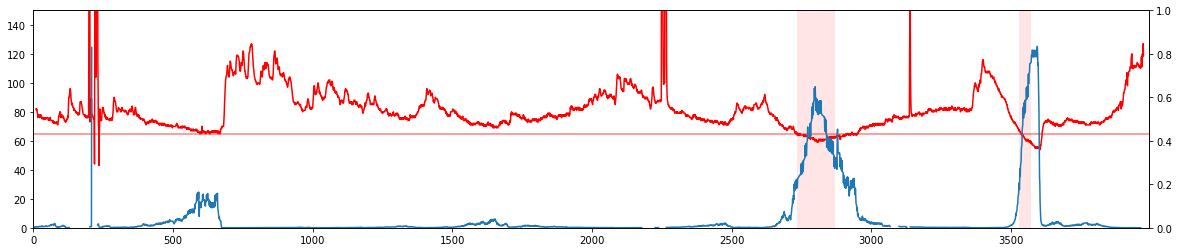

251/251 [==============================] - 1s 4ms/step
5203	0.10109711816091131	


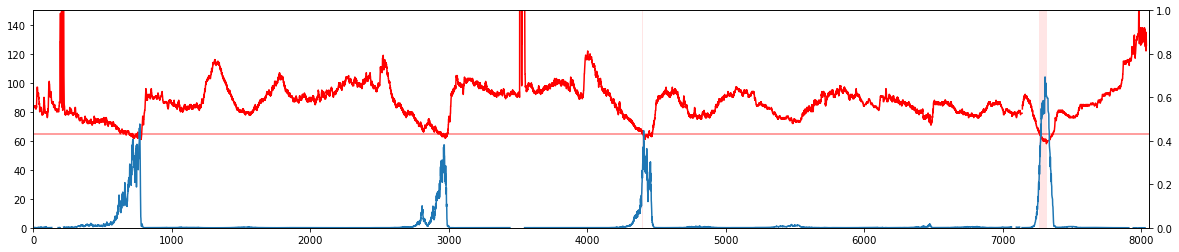

104/104 [==============================] - 0s 4ms/step
5230	0.21259397434310817	


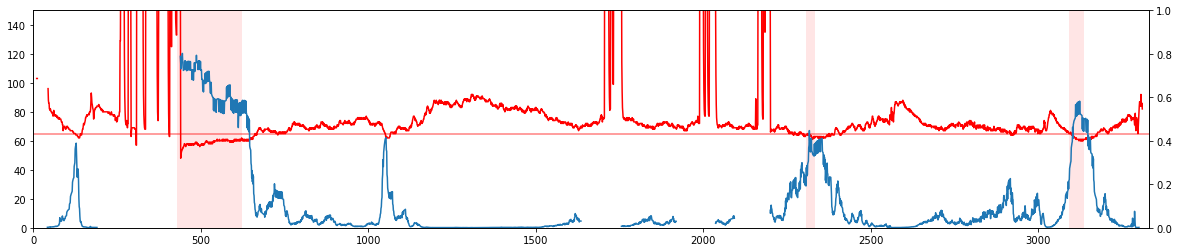

101/101 [==============================] - 0s 4ms/step
5270	0.07341200215967184	


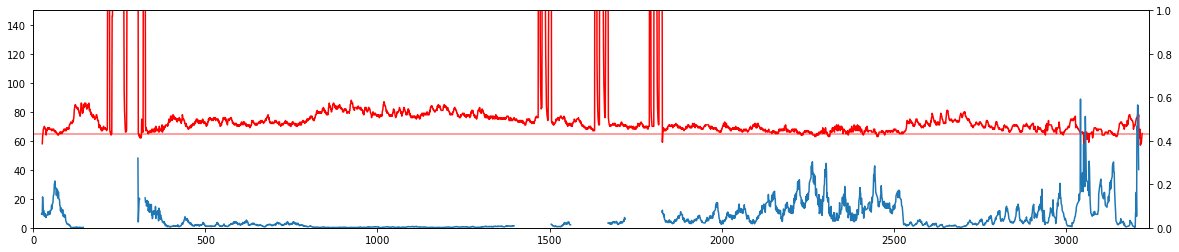

201/201 [==============================] - 1s 4ms/step
5295	0.04967816025896531	


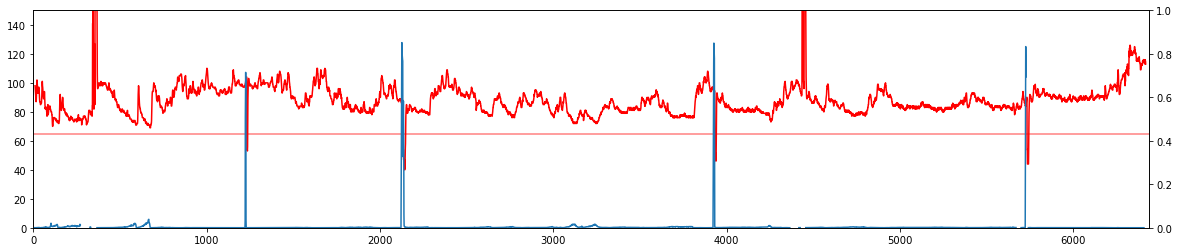

88/88 [==============================] - 0s 4ms/step
5324	0.20872361858782104	


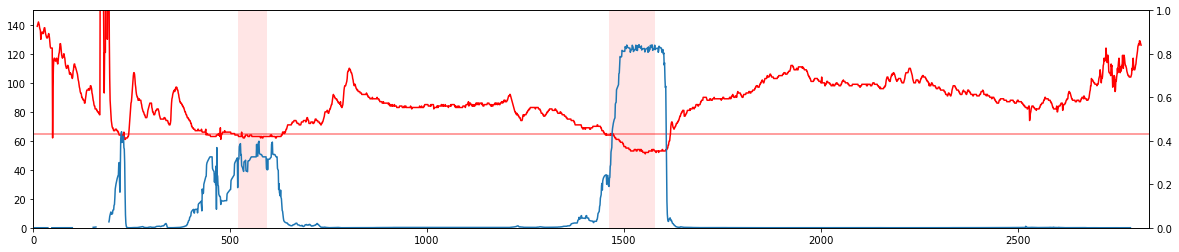

191/191 [==============================] - 1s 5ms/step
5404	0.2659543884195339	


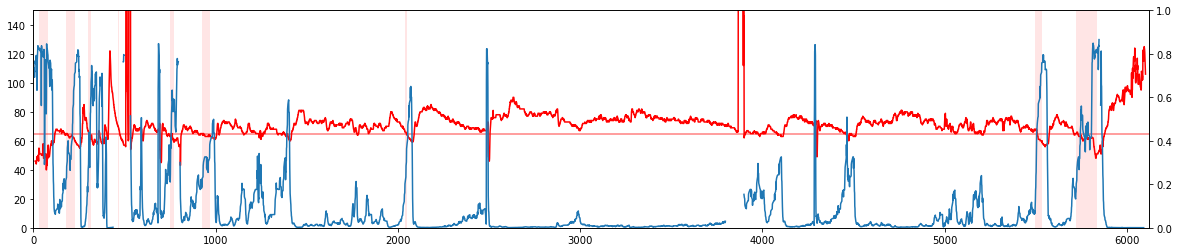

254/254 [==============================] - 1s 4ms/step
5423	0.21055577317722596	


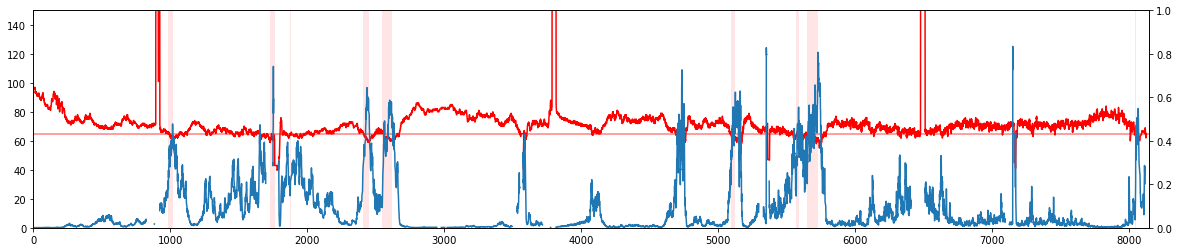

191/191 [==============================] - 1s 4ms/step
5633	0.2688978049344716	


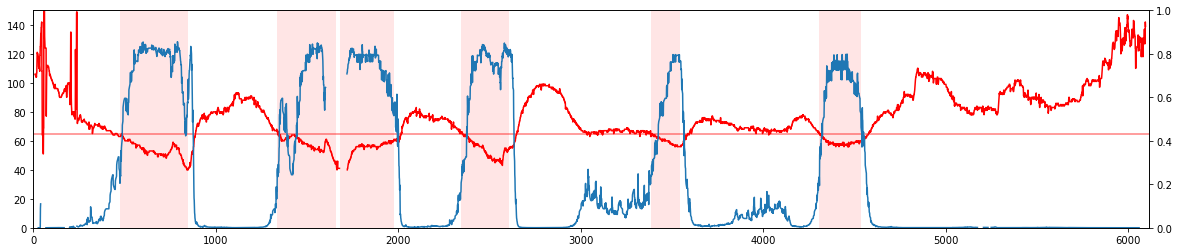

161/161 [==============================] - 1s 4ms/step
5657	0.23260689431581538	


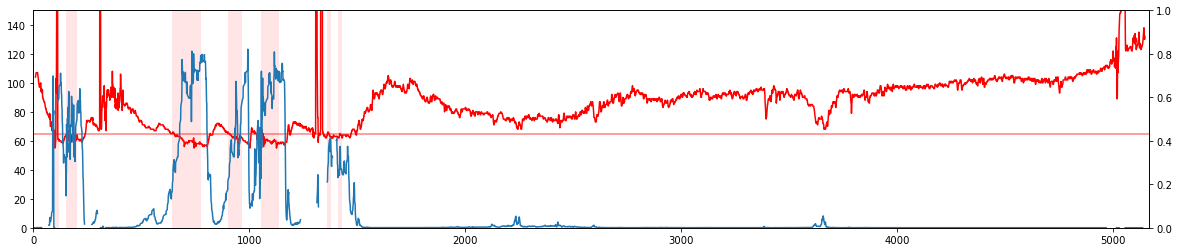

352/352 [==============================] - 2s 5ms/step
5809	0.14907767257605786	


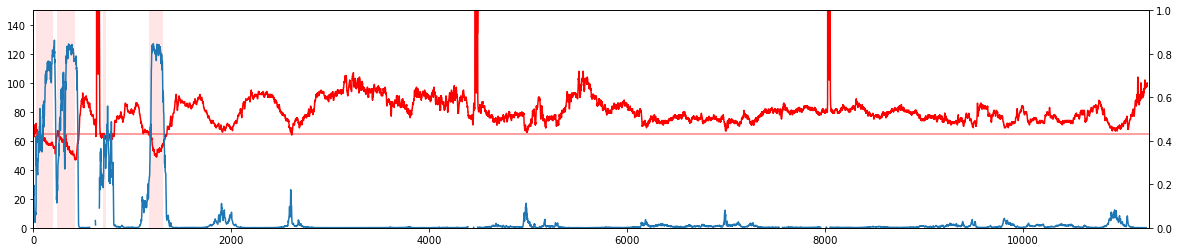

71/71 [==============================] - 0s 5ms/step
5971	0.0004877030511087888	


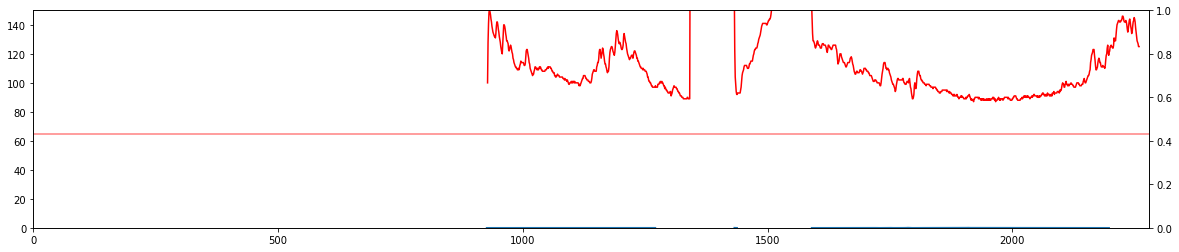

203/203 [==============================] - 1s 4ms/step
6116	0.11735542107890846	


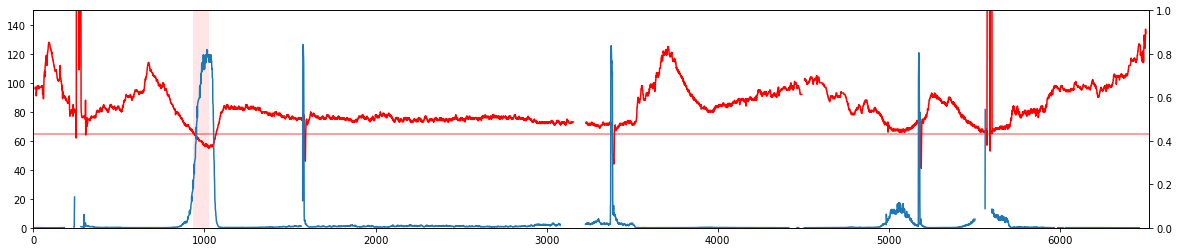

66/66 [==============================] - 0s 4ms/step
6180	0.20120408439185317	


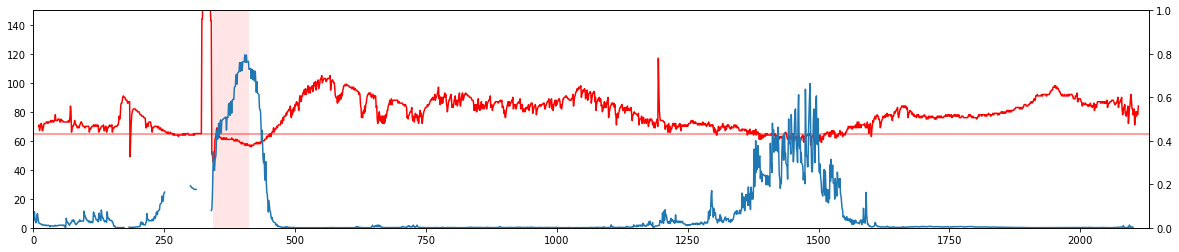

295/295 [==============================] - 1s 4ms/step
6182	0.12841395817865148	


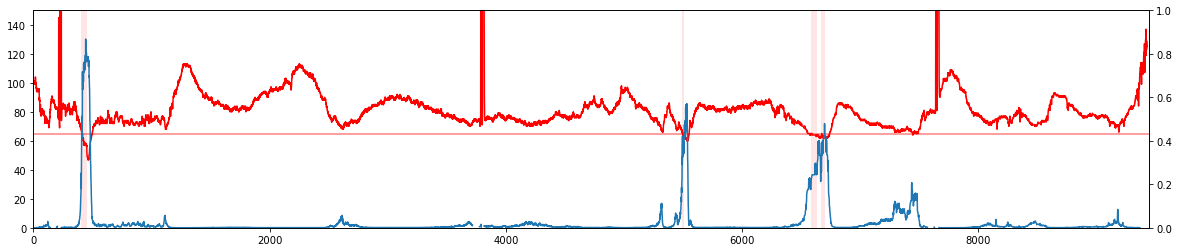

99/99 [==============================] - 0s 4ms/step
6191	0.22644863884946956	


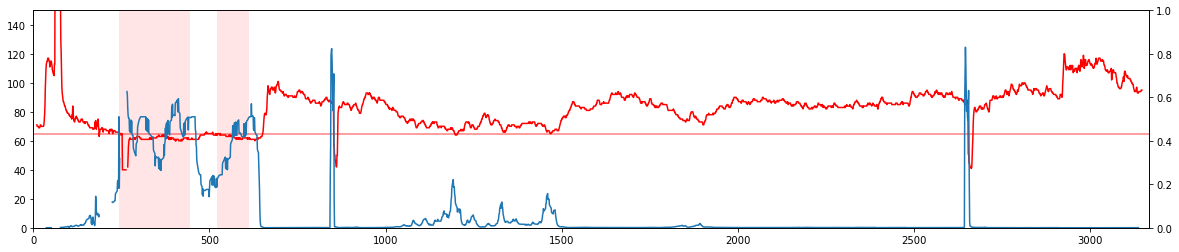

195/195 [==============================] - 1s 4ms/step
6282	0.24559935605763844	


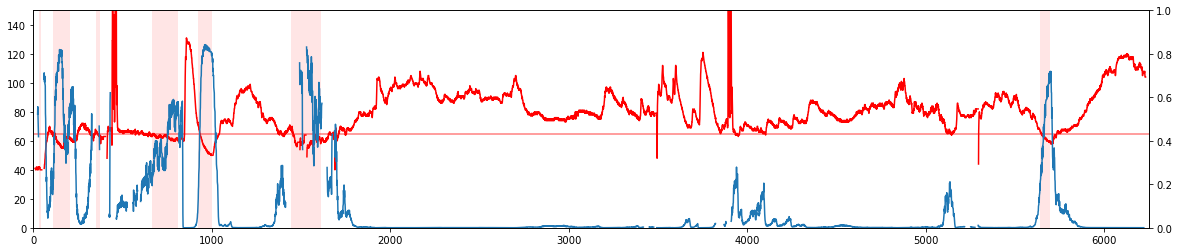

323/323 [==============================] - 1s 4ms/step
6290	0.3678903751368392	


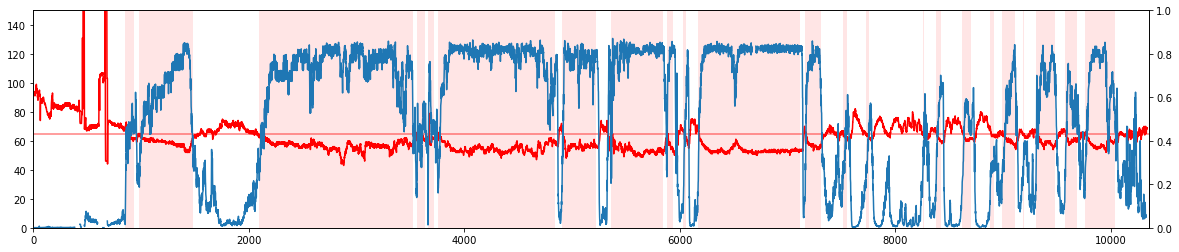

76/76 [==============================] - 0s 4ms/step
6291	0.0010555284071524047	


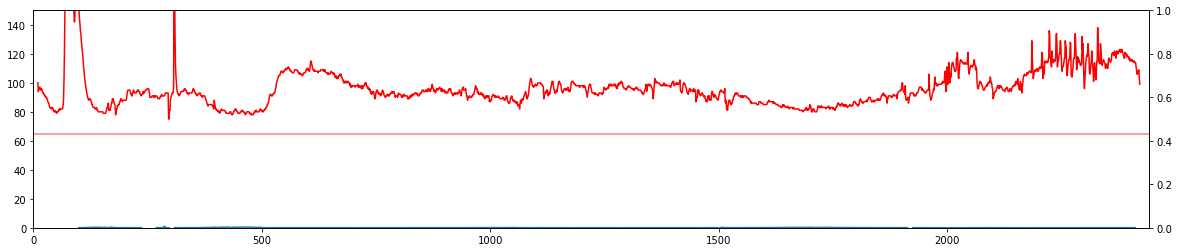

283/283 [==============================] - 1s 4ms/step
6343	0.06093035665238309	


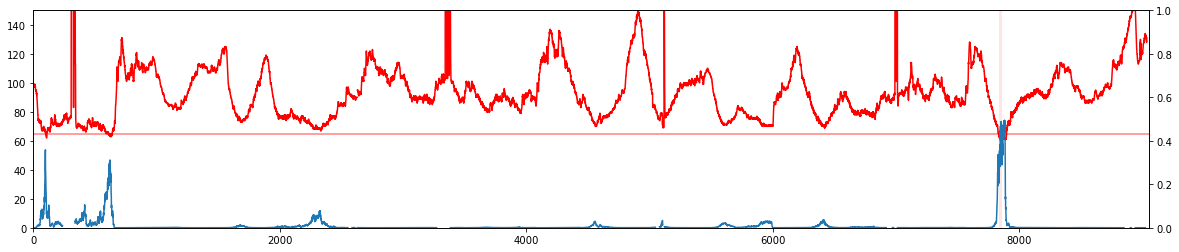

In [9]:
for caseid in caseids_test:
    case_mask = (c == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    case_x = x[case_mask]
    case_y = y[case_mask]
    case_valid_mask = valid_mask[case_mask]
    
    # calculate error for this case
    case_predy = model.predict(case_x).flatten()
    case_rmse = np.nanmean((case_y - case_predy) ** 2) ** 0.5
    print('{}\t{}\t'.format(caseid, case_rmse))

    # draw
    plt.figure(figsize=(20, 4))
    plt.xlim([0, case_len + MINUTES_AHEAD * 30])
    t = np.arange(0, case_len)

    # red bars for the event
    ax1 = plt.gca()
    for i in range(len(case_y)):
        if case_y[i]:
            ax1.axvspan(i + MINUTES_AHEAD * 30, i + MINUTES_AHEAD * 30 + 1, color='r', alpha=0.1, lw=0)

    # 65 mmHg bar
    ax1.axhline(y=65, color='r', alpha=0.5)
    ax1.plot(t + 10, case_x[:,-1], color='r')
    ax1.set_ylim([0, 150])

    ax2 = ax1.twinx()
    
    # draw valid samples
    case_predy[~case_valid_mask] = np.nan
    ax2.plot(t, case_predy)
    ax2.set_ylim([0, 1])
    
    # save
    plt.show()